In [1]:
import os
# 1. Imposta il percorso di Java 11 (usa l'output del comando sopra)
java_home_path = "/Library/Java/JavaVirtualMachines/openjdk-11.jdk/Contents/Home"
os.environ["JAVA_HOME"] = java_home_path

# 2. Aggiungi Java al PATH
os.environ["PATH"] = f"{java_home_path}/bin:{os.environ['PATH']}"

# 3. Verifica (opzionale)
!java -version



openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment Homebrew (build 11.0.27+0)
OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)


In [2]:
import os
from pyspark.sql import SparkSession

# 1. Configurazione ambiente Java e Spark
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-11.jdk/Contents/Home"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.mongodb.spark:mongo-spark-connector_2.12:10.5.0 pyspark-shell"

# 2. Inizializzazione Spark con configurazione esplicita
spark = SparkSession.builder \
    .appName("ClinicalDataAnalysis") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0") \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/cartella_clinica_db.interventi") \
    .getOrCreate()

# 3. Lettura dati con sintassi corretta
df = spark.read \
  .format("mongodb") \
  .option("uri", "mongodb://localhost:27017") \
  .option("database", "cartella_clinica_db") \
  .option("collection", "interventi") \
  .load()

# Verifica
df.show(10)



25/06/15 16:34:45 WARN Utils: Your hostname, MacBook-Air-di-Luigi.local resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
25/06/15 16:34:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/anaconda3/envs/cnr_project/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/luigibarbato/.ivy2/cache
The jars for the packages stored in: /Users/luigibarbato/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d7f950c5-b474-4000-a0d1-964f63e79e43;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.5.0 in central
	found org.mongodb#mongodb-driver-sync;5.1.4 in central
	[5.1.4] org.mongodb#mongodb-driver-sync;[5.1.1,5.1.99)
	found org.mongodb#bson;5.1.4 in central
	found org.mongodb#mongodb-driver-core;5.1.4 in central
	found org.mongodb#bson-record-codec;5.1.4 in central
:: resolution report :: resolve 1574ms :: artifacts dl 5ms
	:: modules in use:
	org.mongodb#bson;5.1.4 from central in [default]
	org.mongodb#bson-record-codec;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-core;5.1.4 from central in [default]
	org.mongodb#mongodb-driver-sync;5.1.4 from central in [default]
	org.mongodb.spark#mongo-sp

+--------------------+--------------------+--------------------+-----+--------+---------------+----------------+--------------+-------------+-----------------+---------------------+--------------------+----------+-------------+-----------------+------------------+-------------+--------------------+---------------------+------------------+--------------------+--------------------------+--------------------+--------------------+-------------------+-------------+---------------+---------------------+--------------+-------------------+-------------------+-------------------+--------------------+-------------+-----------------+-------------+--------------------+------------+----------------------+----------------------+----------------+---------------------+--------------------+--------------------+--------------------+----------------------+--------------------------+-----------------------+--------------------+---------+-----------------+-------------------+----------------------+--------

In [4]:
from pyspark.sql.functions import regexp_extract, col

# Estrae il numero all'inizio della stringa e lo converte in intero
df_clean = df.withColumn("eta_int", regexp_extract(col("eta"), r"(\d+)", 1).cast("int"))

# Calcola l'età media per reparto
df_clean.select("reparto_destinazione", "eta_int") \
    .groupBy("reparto_destinazione") \
    .avg("eta_int") \
    .withColumnRenamed("avg(eta_int)", "eta_media") \
    .orderBy("eta_media", ascending=False) \
    .show()



+--------------------+---------+
|reparto_destinazione|eta_media|
+--------------------+---------+
|     Pronto Soccorso|     51.5|
|                    |     null|
|                null|     null|
+--------------------+---------+



In [7]:
from pyspark.sql.functions import unix_timestamp, col, round

# Converte gli orari in timestamp e calcola la differenza in minuti
df_tempo = df.withColumn("partenza_ts", unix_timestamp(col("ora_partenza_ambulanza"), "HH:mm")) \
             .withColumn("arrivo_ts", unix_timestamp(col("ora_arrivo_ps"), "HH:mm")) \
             .withColumn("durata_minuti", round((col("arrivo_ts") - col("partenza_ts")) / 60))

# Mostra i tempi di occupazione
df_tempo.select("ora_partenza_ambulanza", "ora_arrivo_ps", "durata_minuti") \
        .orderBy(col("durata_minuti").desc()) \
        .show(10)


+----------------------+-------------+-------------+
|ora_partenza_ambulanza|ora_arrivo_ps|durata_minuti|
+----------------------+-------------+-------------+
|                 14:25|        15:05|         40.0|
|                 08:45|        09:24|         39.0|
|                 09:48|        10:25|         37.0|
|                 14:33|        15:10|         37.0|
|                 09:23|        10:00|         37.0|
|                 10:18|        10:49|         31.0|
|                  null|         null|         null|
|                  null|         null|         null|
|                  null|         null|         null|
|                  null|         null|         null|
+----------------------+-------------+-------------+



In [8]:
# Top 10 città con più interventi
df.groupBy("citta") \
  .count() \
  .orderBy("count", ascending=False) \
  .show(10)


+--------+-----+
|   citta|count|
+--------+-----+
|   Parma|    3|
| Fidenza|    2|
| Bologna|    1|
|  Milano|    1|
|  Modena|    1|
| Firenze|    1|
|Piacenza|    1|
+--------+-----+



In [9]:
total = df.count()

df.groupBy("codice_uscita") \
  .count() \
  .withColumn("percentuale", (col("count") / total) * 100) \
  .orderBy("percentuale", ascending=False) \
  .show()


+-------------+-----+-----------+
|codice_uscita|count|percentuale|
+-------------+-----+-----------+
|           D3|    4|       40.0|
|           D2|    3|       30.0|
|           D1|    2|       20.0|
|           D4|    1|       10.0|
+-------------+-----+-----------+



In [10]:
df_eff = df.groupBy("codice_uscita", "codice_rientro") \
           .count() \
           .orderBy("count", ascending=False)

df_eff.show(10)


+-------------+--------------+-----+
|codice_uscita|codice_rientro|count|
+-------------+--------------+-----+
|           D3|            D4|    3|
|           D3|            D3|    1|
|           D2|            D4|    1|
|           D1|            D3|    1|
|           D2|            D3|    1|
|           D4|            D5|    1|
|           D1|            D1|    1|
|           D2|            D2|    1|
+-------------+--------------+-----+



/var/folders/7f/7v0y2r7x71d8fvv9hcm5rtx80000gn/T/ipykernel_10261/2987412968.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eta_df, x="reparto_destinazione", y="eta_media", palette="viridis")


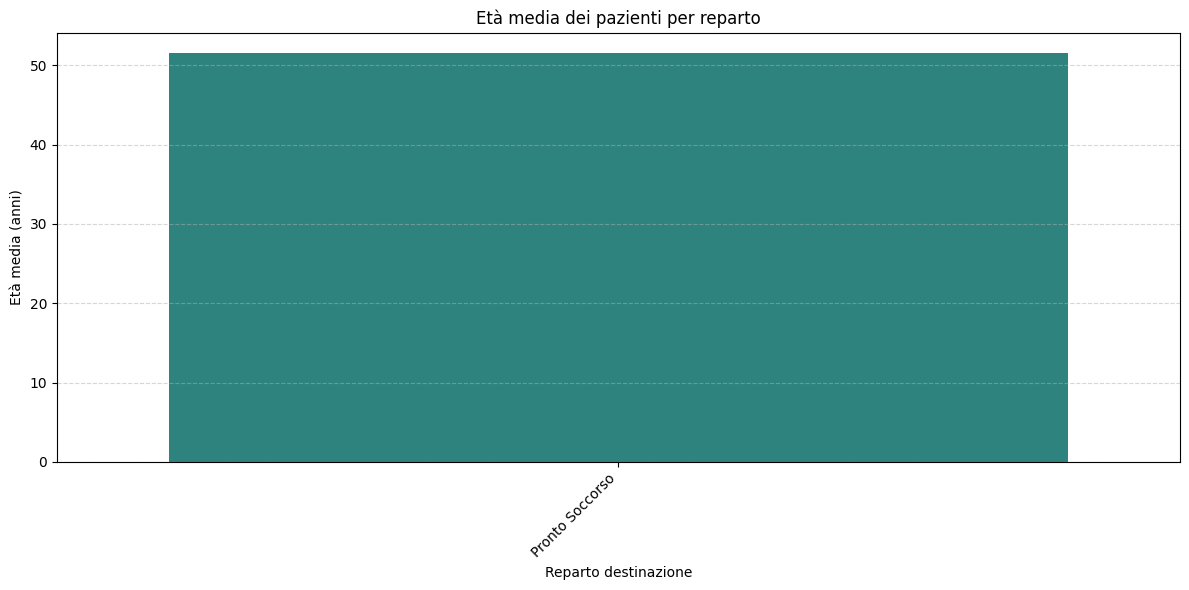

In [13]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Estrae il numero all'inizio della stringa e lo converte in intero
df_clean = df.withColumn("eta_int", regexp_extract(col("eta"), r"(\d+)", 1).cast("int"))


# Calcolo dell'età media per reparto
eta_df = df_clean.select("reparto_destinazione", "eta_int") \
                 .groupBy("reparto_destinazione") \
                 .avg("eta_int") \
                 .withColumnRenamed("avg(eta_int)", "eta_media") \
                 .orderBy("eta_media", ascending=False) \
                 .toPandas()

# Rimozione reparti null o vuoti
eta_df = eta_df[eta_df["reparto_destinazione"].notnull()]
eta_df = eta_df[eta_df["reparto_destinazione"].str.strip() != ""]

# Plot ordinato
plt.figure(figsize=(12, 6))
sns.barplot(data=eta_df, x="reparto_destinazione", y="eta_media", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Età media (anni)")
plt.xlabel("Reparto destinazione")
plt.title("Età media dei pazienti per reparto")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
